In [127]:
from headers import *
# %matplotlib notebook

Defining a Class for DMPs

In [128]:
class DMP():
	
	def __init__(self):

		self.alphaz = 25.0
		self.betaz = self.alphaz/4
		self.alpha = 1*self.alphaz/3    
        
		self.time_steps = 100
		self.tau = self.time_steps

		self.dimensions = 3
		self.number_kernels = 100
		self.gaussian_kernels = npy.zeros((self.number_kernels,2))

		self.weights = npy.zeros((self.number_kernels, self.dimensions))

		self.demo_pos = npy.zeros((self.time_steps, self.dimensions))
		self.demo_vel = npy.zeros((self.time_steps, self.dimensions))
		self.demo_acc = npy.zeros((self.time_steps, self.dimensions))

		self.target_forces = npy.zeros((self.time_steps, self.dimensions))        
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))
		self.vector_phase = npy.zeros(self.time_steps)
        
# Defining Rollout variables.
		self.rollout_time = self.time_steps
		self.dt = 1./self.rollout_time
		self.pos_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.acc_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.force_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.pos_var = npy.zeros(self.dimensions)
		self.vel_var = npy.zeros(self.dimensions)
		self.acc_var = npy.zeros(self.dimensions)        
		self.force_var = npy.zeros(self.dimensions)        
		self.goal = npy.zeros(self.dimensions)
		self.start = npy.zeros(self.dimensions)        

	def load_trajectory(self,pos,vel,acc):
		self.demo_pos = copy.deepcopy(pos)
		self.demo_vel = copy.deepcopy(vel)
		self.demo_acc = copy.deepcopy(acc)

	def initialize_variables(self):	
		self.weights = npy.zeros((self.number_kernels, self.dimensions))
		self.target_forces = npy.zeros((self.time_steps, self.dimensions))
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))

		t_range = npy.linspace(0,self.time_steps,self.number_kernels)
# 		t_range_2 = npy.linspace(0,self.time_steps,self.time_steps)        
		self.vector_phase = self.calc_vector_phase(t_range)
		self.gaussian_kernels[:,0] = self.vector_phase
        
# Experiment with the variance of the Guassian Kernels.
# Higher variance helps reach the target values more accurately. 
# The rolled out trajectory is worse. 

		self.gaussian_kernels[:,1] = self.number_kernels/self.gaussian_kernels[:,0]       
# 		dummy = (npy.diff(self.gaussian_kernels[:,0]*2))**2        
# 		dummy = (npy.diff(self.gaussian_kernels[:,0]*0.05))**2            
# 		self.gaussian_kernels[:,1] = 1. / npy.append(dummy,dummy[-1])

	def calc_phase(self,time):
		return npy.exp(-self.alpha*float(time)/self.tau)
    
	def calc_vector_phase(self,time):
		return npy.exp(-self.alpha*time.astype(float)/self.tau)

	def basis(self,index,time):
		return npy.exp(-(self.gaussian_kernels[index,1])*((self.calc_phase(time)-self.gaussian_kernels[index,0])**2))

	def update_target_force(self):
		self.target_forces = self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel)
    
  	def update_target_force_itau(self):
		self.target_forces = (self.tau**2)*self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.tau*self.demo_vel)
        
  	def update_target_force_dtau(self):
		self.target_forces = self.demo_acc/(self.tau**2) - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel/self.tau)    

	def update_phi(self):		
		for i in range(self.number_kernels):
			for t in range(self.time_steps):
				self.phi[i,t,t] = self.basis(i,t)                
                
	def update_eta(self):        
		t_range = npy.linspace(0,self.time_steps,self.time_steps)        
		vector_phase = self.calc_vector_phase(t_range)        
        
		for k in range(self.dimensions):
			self.eta[:,k] = vector_phase*(self.demo_pos[-1,k]-self.demo_pos[0,k])
# 		self.eta[:,0] = vector_phase*(self.demo_pos[self.time_steps-1,0]-self.demo_pos[0,0])
# 		self.eta[:,1] = vector_phase*(self.demo_pos[self.time_steps-1,1]-self.demo_pos[0,1])

	def learn_DMP(self):	
# 		self.update_target_force()        
		self.update_phi()
		self.update_eta()

		for j in range(self.dimensions):
			for i in range(self.number_kernels):
				self.weights[i,j] = npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.target_forces[:,j]))
				self.weights[i,j] /= npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.eta[:,j]))

	def save_DMP_parameters(self,file_suffix):

		with file("force_weights_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile,self.weights)
	
		with file("position_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile, self.demo_pos)
            
	def shebang(self,pos,vel,acc):
		dmp.load_trajectory(pos,vel,acc)
		dmp.initialize_variables()
		dmp.learn_DMP() 
        
	def initialize_rollout(self,start,goal):
		self.tau = 1
		self.pos_var = copy.deepcopy(start)
		self.pos_roll[0] = copy.deepcopy(start)
		self.vel_var = npy.zeros(self.dimensions)
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.goal = goal
		self.start = start
		self.dt = 1./self.rollout_time    

	def calc_rollout_force(self,roll_time):
		den = 0        
		time = float(roll_time)/self.rollout_time           
		print(roll_time,time,self.calc_phase(time),self.tau)
		for i in range(self.number_kernels):
			self.force_roll[roll_time] += self.basis(i,time)*self.weights[i]
			den += self.basis(i,time)
		self.force_roll[roll_time] *= (self.goal-self.pos_roll[0])*self.calc_phase(time)/den
            
	def calc_rollout_acceleration(self,time):        
		self.acc_var = (1/self.tau**2)*(self.alphaz * (self.betaz * (self.goal - self.pos_var) - self.tau*self.vel_var) + self.force_roll[time])
		self.acc_roll[time] = copy.deepcopy(self.acc_var)
        
	def calc_rollout_vel(self,time):
		self.vel_var += (1/self.tau)*self.acc_var*self.dt
		self.vel_roll[time] = copy.deepcopy(self.vel_var)

	def calc_rollout_pos(self,time):
		self.pos_var += self.vel_var * self.dt 
# 		self.pos_var += self.vel_var * self.dt + 0.5 * self.acc_var *(self.dt**2)        
		self.pos_roll[time] = copy.deepcopy(self.pos_var)

	def rollout(self,start,goal):

		# For all time: 
		self.initialize_rollout(start,goal)
		for i in range(self.rollout_time):        
			self.calc_rollout_force(i)
			self.calc_rollout_acceleration(i)
			self.calc_rollout_vel(i)
			self.calc_rollout_pos(i)   

In [129]:
# cd Subject1/Traj_0/Segment_0/

In [162]:
dmp = DMP()	

pos = npy.load("lh_pos.npy")[:,:3]
vel = npy.load("lh_vel.npy")[:,:3]
acc = npy.load("lh_acc.npy")[:,:3]

# ts = 1000
ts = 1
vel *= ts
acc *= (ts**2)

In [163]:
pos.shape,vel.shape,acc.shape

((100, 3), (100, 3), (100, 3))

In [164]:
dmp.load_trajectory(pos,vel,acc)
dmp.initialize_variables()
# dmp.update_target_force()
dmp.update_target_force_itau()
# dmp.update_target_force_dtau()
dmp.learn_DMP()

tr = npy.linspace(0,dmp.time_steps-1,dmp.time_steps)

<IPython.core.display.Javascript object>


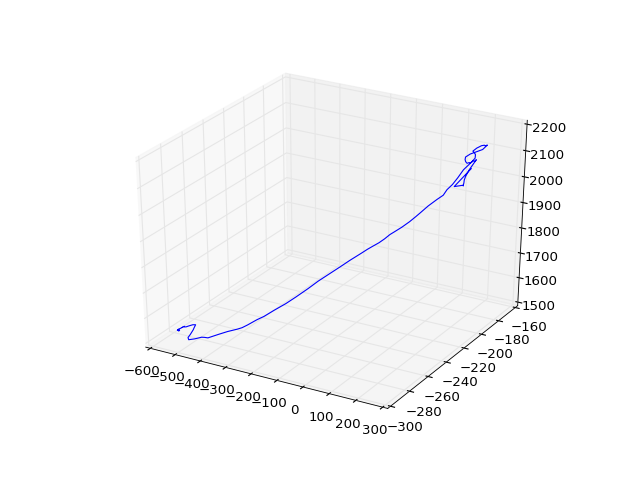

In [165]:
# MODIFYING TO 3D PLOTS: 

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(pos[:,0],pos[:,1],pos[:,2])

# ax.plot(vel[:,0],vel[:,1],vel[:,2])
plt.ioff()
plt.show()

# plt.plot(dmp.demo_pos[:,0],dmp.demo_pos[:,1])
# plt.title("Trajectory Positions to learn DMP.")
# plt.show()

<IPython.core.display.Javascript object>


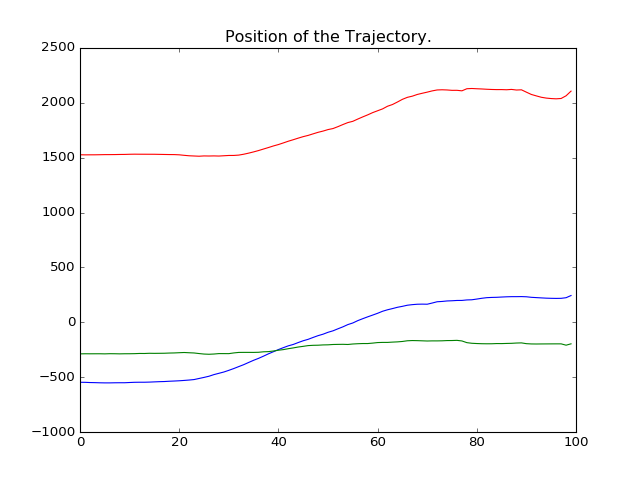

In [144]:
plt.plot(range(dmp.time_steps),dmp.demo_pos)
plt.title("Position of the Trajectory.")
plt.show()

<IPython.core.display.Javascript object>


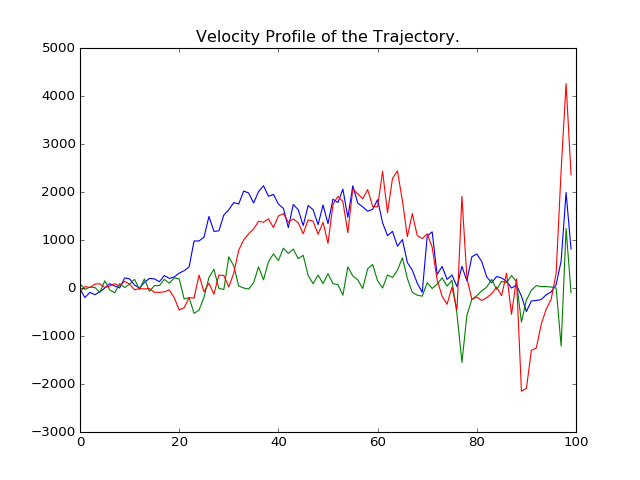

In [137]:
plt.plot(range(dmp.time_steps),dmp.demo_vel)
# plt.plot(range(dmp.time_steps),dmp.demo_vel*dmp.tau)
plt.title("Velocity Profile of the Trajectory.")
plt.show()

<IPython.core.display.Javascript object>


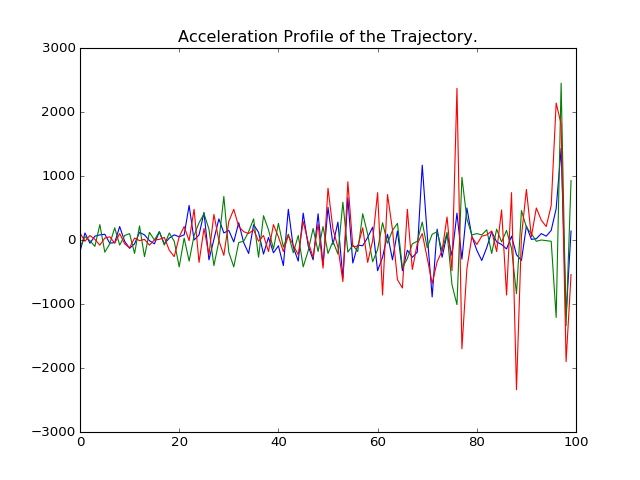

In [161]:
plt.plot(range(dmp.time_steps),dmp.demo_acc)
plt.title("Acceleration Profile of the Trajectory.")
plt.show()

# npy.where(abs(dmp.demo_acc[:,0]/(dmp.tau**2))>0.5),npy.where(abs(dmp.demo_acc[:,1]/(dmp.tau**2))>0.5)

<IPython.core.display.Javascript object>


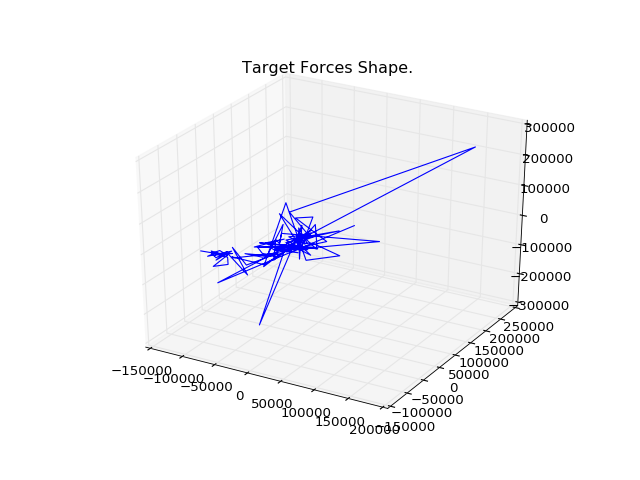

In [167]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(dmp.target_forces[:,0],dmp.target_forces[:,1],dmp.target_forces[:,2])
# plt.plot(dmp.target_forces[:,0],dmp.target_forces[:,1])
plt.title("Target Forces Shape.")
plt.show()

<IPython.core.display.Javascript object>


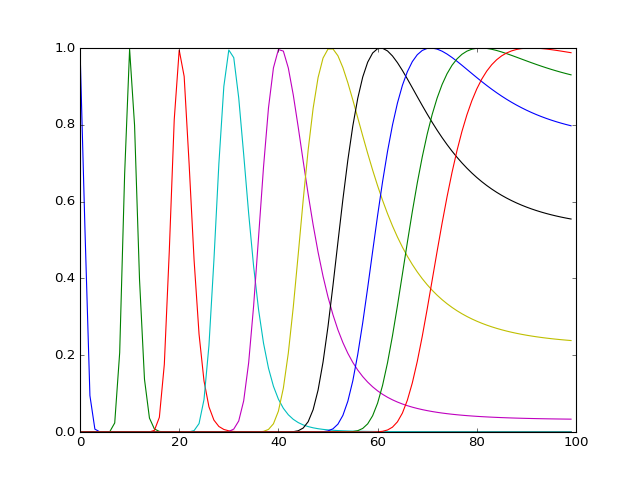

In [85]:
b = npy.zeros((dmp.number_kernels,dmp.time_steps))
# dmp.tau = 100
# dmp.gaussian_kern
# for i in range(dmp.number_kernels):
#     for t in range(dmp.time_steps):
#         b[i,t]=dmp.basis(i,t)        
#     plt.plot(tr,b[i])    

for i in range(10):
    for t in range(dmp.time_steps):
        b[i,t]=dmp.basis(i*10,t)        
    plt.plot(tr,b[i])    
    
    
plt.show()
# dmp.tau =100 

<IPython.core.display.Javascript object>


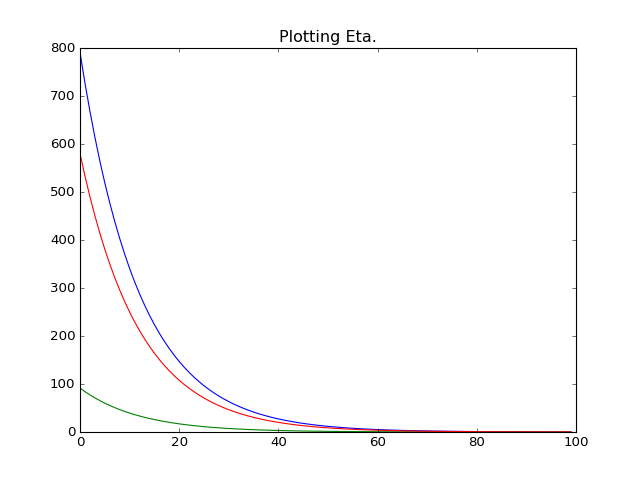

In [86]:
plt.plot(range(dmp.time_steps),dmp.eta)
plt.title("Plotting Eta.")
plt.show()

<IPython.core.display.Javascript object>


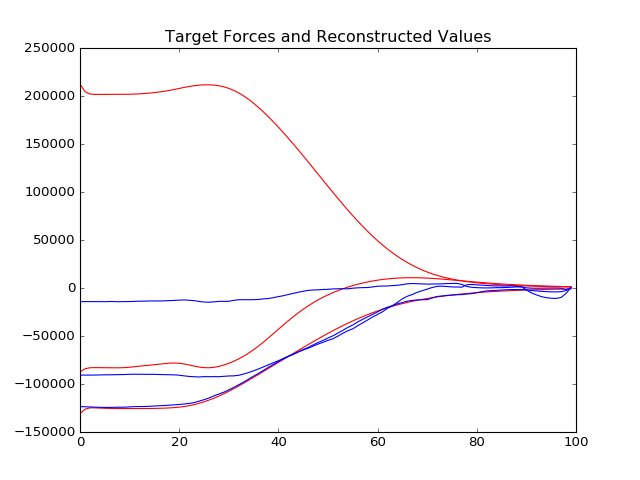

In [87]:
force = npy.zeros((dmp.time_steps,dmp.dimensions))
dmp.goal = copy.deepcopy(dmp.demo_pos[-1])

for t in range(dmp.time_steps):
    den = 0
    for i in range(dmp.number_kernels):
        force[t] += dmp.weights[i]*dmp.basis(i,t)
        den += dmp.basis(i,t)   
    for k in range(dmp.dimensions):
        force[t,k]*=(dmp.goal[0]-dmp.demo_pos[0,k])*dmp.calc_phase(t)/den
#         force[t,1]*=(dmp.goal[1]-dmp.demo_pos[0,1])*dmp.calc_phase(t)/den
    
# plt.plot(tr,force)
# plt.show()

plt.plot(tr,force,'r',label='Reconstructed Forces')
plt.plot(tr,dmp.target_forces,'b',label='Target Forces')
# t=2
# plt.plot([t,t],[-600,0],'g')
plt.title("Target Forces and Reconstructed Values")
# plt.legend()
plt.show()

<IPython.core.display.Javascript object>


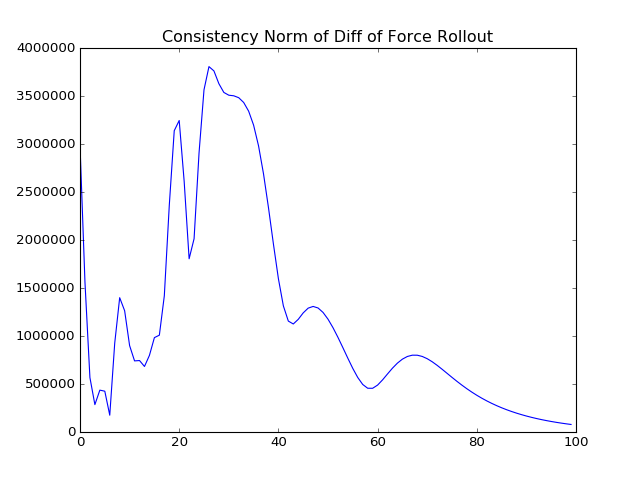

In [70]:
# loss = npy.linalg.norm(force-dmp.target_forces,axis=1)
force_diff = npy.linalg.norm(npy.diff(force,axis=0),axis=1)
force_norm = npy.linalg.norm(force,axis=1)
plt.plot(range(dmp.time_steps),force_norm)
plt.title("Consistency Norm of Diff of Force Rollout")
plt.show()

In [168]:
start = npy.zeros(dmp.dimensions)
goal = npy.ones(dmp.dimensions)
dmp.rollout(start, goal)

(0, 0.0, 1.0, 1)
(1, 0.01, 0.92004441462932329, 1)
(2, 0.02, 0.84648172489061402, 1)
(3, 0.03, 0.77880078307140488, 1)
(4, 0.04, 0.71653131057378927, 1)
(5, 0.05, 0.65924063020044366, 1)
(6, 0.06, 0.60653065971263342, 1)
(7, 0.07, 0.55803514577004698, 1)
(8, 0.08, 0.51341711903259202, 1)
(9, 0.09, 0.47236655274101469, 1)
(10, 0.1, 0.43459820850707814, 1)
(11, 0.11, 0.39984965434484732, 1)
(12, 0.12, 0.36787944117144233, 1)
(13, 0.13, 0.33846542510674216, 1)
(14, 0.14, 0.31140322391459757, 1)
(15, 0.15, 0.28650479686019009, 1)
(16, 0.16, 0.26359713811572671, 1)
(17, 0.17, 0.24252107463564865, 1)
(18, 0.18, 0.22313016014842982, 1)
(19, 0.19, 0.20528965757990925, 1)
(20, 0.2, 0.18887560283756177, 1)
(21, 0.21, 0.17377394345044514, 1)
(22, 0.22, 0.15987974607969388, 1)
(23, 0.23, 0.14709646739297677, 1)
(24, 0.24, 0.1353352832366127, 1)
(25, 0.25, 0.12451447144412296, 1)
(26, 0.26, 0.11455884399268769, 1)
(27, 0.27, 0.10539922456186429, 1)
(28, 0.28, 0.096971967864405012, 1)
(29, 0.29, 0.0

<IPython.core.display.Javascript object>


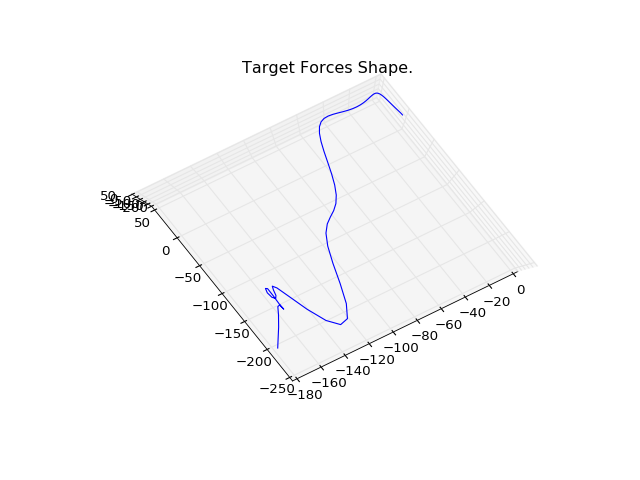

In [169]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(dmp.force_roll[:,0],dmp.force_roll[:,1],dmp.force_roll[:,2])
# plt.plot(dmp.target_forces[:,0],dmp.target_forces[:,1])
plt.title("Target Forces Shape.")
plt.show()

<IPython.core.display.Javascript object>


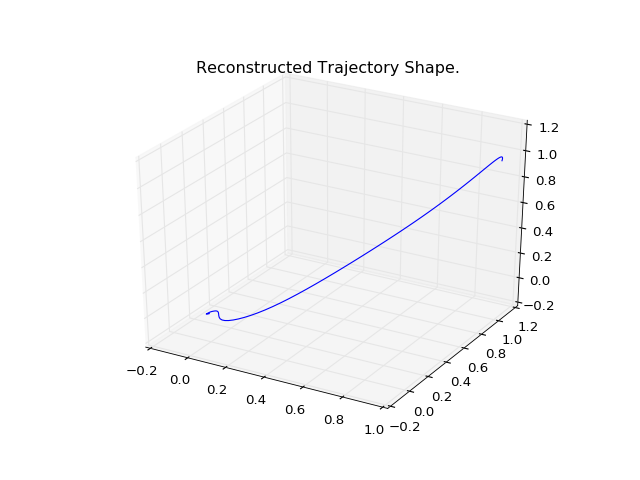

In [170]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(dmp.pos_roll[:,0],dmp.pos_roll[:,1],dmp.pos_roll[:,2])
plt.title("Reconstructed Trajectory Shape.")
plt.show()